In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

In [3]:

## 2. Cargar Datos
df = pd.read_csv("../data/raw/demanding_forecast.csv")
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha')
print(df.head())

           fecha  prod_id  precio_promedio  ventas  modelo_actual
56064 2012-01-01      698      8280.073778   436.0     441.953878
13632 2012-01-01      167      1961.219324  1880.0    1960.518724
27180 2012-01-01      331      4843.074738   819.0     860.015182
75084 2012-01-01      931     12346.697520  1408.0    1351.436692
42972 2012-01-01      530      6194.495105  1540.0    1522.800893


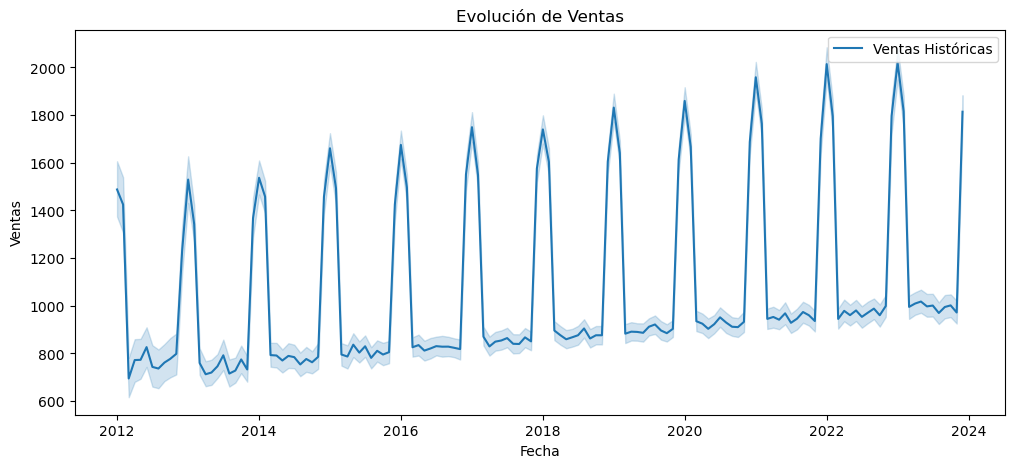

In [4]:
## 3. Exploración de Datos
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='fecha', y='ventas', label='Ventas Históricas')
plt.title("Evolución de Ventas")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

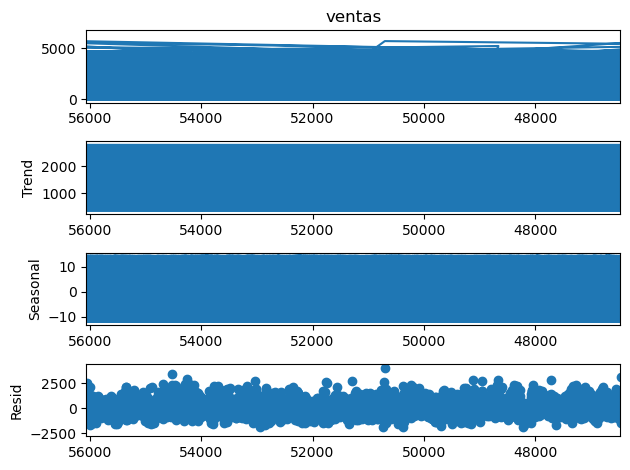

In [7]:
## 4. Análisis de Estacionalidad y Tendencia
# Descomposición de la serie temporal
result = seasonal_decompose(df['ventas'], model='additive', period=12)
result.plot()
plt.show()

In [8]:
# Prueba de estacionaridad (Dickey-Fuller)
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Conclusión: La serie es estacionaria' if result[1] < 0.05 else 'Conclusión: La serie NO es estacionaria')

adf_test(df['ventas'])

ADF Statistic: -8.365228575953044
p-value: 2.7544560518797455e-13
Conclusión: La serie es estacionaria


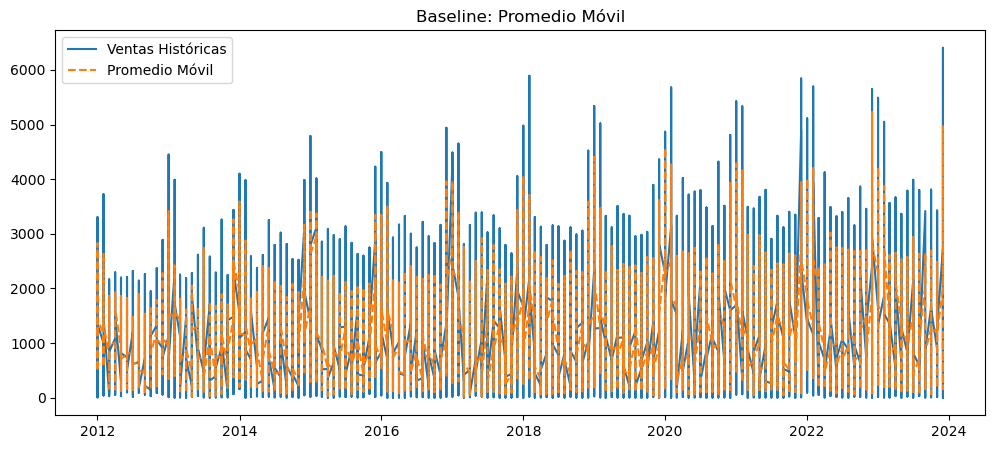

In [15]:
## 5. Baseline con Promedio Móvil
rolling_avg = df['ventas'].rolling(window=2).mean()
plt.figure(figsize=(12,5))
plt.plot(df['fecha'], df['ventas'], label='Ventas Históricas')
plt.plot(df['fecha'], rolling_avg, label='Promedio Móvil', linestyle='dashed')
plt.legend()
plt.title("Baseline: Promedio Móvil")
plt.show()

In [ ]:


## 6. Optimización de ARIMA
modelo_arima_auto = pm.auto_arima(df['ventas'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
print(modelo_arima_auto.summary())

modelo_arima = ARIMA(df['ventas'], order=modelo_arima_auto.order)
modelo_arima_fit = modelo_arima.fit()
print(modelo_arima_fit.summary())

# Predicción con ARIMA
predicciones_arima = modelo_arima_fit.forecast(steps=12)

plt.figure(figsize=(12,5))
plt.plot(df['fecha'], df['ventas'], label='Ventas Históricas')
plt.plot(pd.date_range(df['fecha'].iloc[-1], periods=12, freq='M'), predicciones_arima, label='Predicción ARIMA', linestyle='dashed')
plt.legend()
plt.title("Proyección de Ventas con ARIMA")
plt.show()

## 7. Feature Engineering para XGBoost
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year
df['lag_1'] = df['ventas'].shift(1)
df['lag_12'] = df['ventas'].shift(12)
df.dropna(inplace=True)

X = df[['mes', 'año', 'precio_promedio', 'lag_1', 'lag_12']]
y = df['ventas']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
modelo_xgb.fit(X_train, y_train)

# Predicción con XGBoost
y_pred = modelo_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE de XGBoost: {mae_xgb}')
print(f'RMSE de XGBoost: {rmse_xgb}')

plt.figure(figsize=(12,5))
sns.lineplot(x=X_test['año'] + X_test['mes']/12, y=y_test, label='Ventas Reales')
sns.lineplot(x=X_test['año'] + X_test['mes']/12, y=y_pred, label='Predicción XGBoost')
plt.title("Proyección de Ventas con XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

## 8. Generación de Predicciones para 2024 con XGBoost
dates_2024 = pd.date_range(start='2024-01-01', periods=12, freq='M')
pred_2024 = pd.DataFrame({'fecha': dates_2024})
pred_2024['mes'] = pred_2024['fecha'].dt.month
pred_2024['año'] = pred_2024['fecha'].dt.year
pred_2024['precio_promedio'] = df['precio_promedio'].mean()
pred_2024['lag_1'] = df['ventas'].iloc[-1]
pred_2024['lag_12'] = df['ventas'].iloc[-12]

pred_2024['ventas_pred'] = modelo_xgb.predict(pred_2024[['mes', 'año', 'precio_promedio', 'lag_1', 'lag_12']])
pred_2024.to_csv("predicciones_2024_xgb.csv", index=False)
print("Predicciones XGBoost exportadas correctamente.")

## 9. Comparación de Modelos
print(f'MAE ARIMA: {mean_absolute_error(y_test, modelo_arima_fit.forecast(len(y_test)))}')
print(f'MAE XGBoost: {mae_xgb}')
print(f'RMSE ARIMA: {np.sqrt(mean_squared_error(y_test, modelo_arima_fit.forecast(len(y_test))))}')
print(f'RMSE XGBoost: {rmse_xgb}')
